In [87]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\Pablo\AppData\Local\Temp\ipykernel_20576\2026922495.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


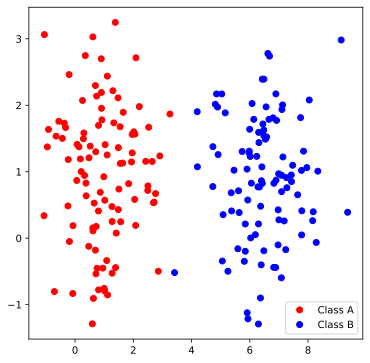

In [168]:
# create data
points_per_cluster = 100
blur = 1.0 # increase this value to make the clusters more blurry

A = [1, 1] # center of the first cluster
B = [6.5, 1] # center of the second cluster

# generate data
np.random.seed(7) # for reproducibility
data_A = np.random.randn(points_per_cluster, 2) * blur + A
data_B = np.random.randn(points_per_cluster, 2) * blur + B
data = np.concatenate([data_A, data_B])

# true labels
labels_A = np.zeros(points_per_cluster) # class 0
labels_B = np.ones(points_per_cluster) # class 1
labels = np.concatenate([labels_A, labels_B])

# convert to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

# visualize data
fig = plt.figure(figsize=(6, 6))
plt.plot(data_A[:, 0], data_A[:, 1], 'ro', label='Class A')
plt.plot(data_B[:, 0], data_B[:, 1], 'bo', label='Class B')
plt.legend()
plt.show()

In [169]:
print(type(data), data.shape)
print(type(labels), labels.shape)

<class 'torch.Tensor'> torch.Size([200, 2])
<class 'torch.Tensor'> torch.Size([200])


In [170]:
# build the model
ANNclassify = nn.Sequential(
    nn.Linear(2, 1), # input layer
    nn.ReLU(), # activation function
    nn.Linear(1, 1), # output layer
    nn.Sigmoid() # final activation for binary classification
)

ANNclassify

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Sigmoid()
)

In [171]:
# other model features
learning_rate = 0.01
loss_fn = nn.BCELoss() # binary cross-entropy loss for binary classification
optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learning_rate)

In [172]:
# train the model
num_epochs = 1000
losses = torch.zeros(num_epochs)
for epoch in range(num_epochs):
    # forward pass
    y_pred = ANNclassify(data)

    # compute loss
    loss = loss_fn(y_pred.squeeze(), labels) # squeeze to go from (200, 1) to (200,)
    losses[epoch] = loss

    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

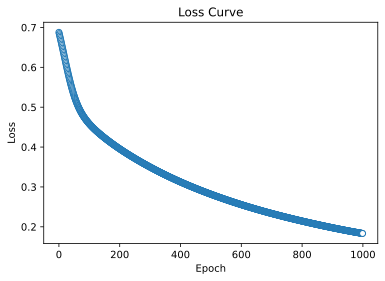

In [173]:
# show the loss curve
plt.figure(figsize=(6, 4))
plt.plot(losses.detach(), "o", markerfacecolor="w")
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# when we see the loss curve hasn't still converged we can:
# 1. increase the number of epochs
# 2. increase the learning rate

In [174]:
# compute the predicted labels
predictions = ANNclassify(data).squeeze() # shape (200, 1) -> (200,)
predicted_labels = (predictions >= 0.5).float() # threshold at 0.5

missclassified = (predicted_labels != labels)
accuracy = (predicted_labels == labels).float().mean().item()
print(f'Missclassified samples: {missclassified.sum().item()} out of {len(labels)}')
print(f'Accuracy: {accuracy * 100:.2f}%')

Missclassified samples: 6 out of 200
Accuracy: 97.00%


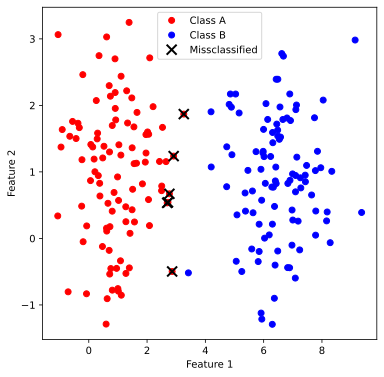

In [175]:
fig = plt.figure(figsize=(6, 6))
plt.plot(data[labels==0][:, 0], data[labels==0][:, 1], 'ro', label='Class A')
plt.plot(data[labels==1][:, 0], data[labels==1][:, 1], 'bo', label='Class B')
plt.plot(data[missclassified, 0], data[missclassified, 1], 'kx', label='Missclassified', markersize=10, markeredgewidth=2)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [176]:
def createANNmodel(learning_rate, seed=13):
    torch.manual_seed(seed) # for reproducibility and to have the same initial weights across different runs
    # we can comment the torch.manual seed to have different initial weights and see how it affects the 
    # training process and final accuracy
    model = nn.Sequential(
        nn.Linear(2, 1),
        nn.ReLU(),
        nn.Linear(1, 1),
        #nn.Sigmoid() # Pytorch recommends using BCEWithLogitsLoss which combines sigmoid and binary cross-entropy loss
    )
    loss_fn = nn.BCEWithLogitsLoss() # combines sigmoid and binary cross-entropy loss
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    return model, loss_fn, optimizer

def trainANNmodel(model, loss_fn, optimizer, data, labels, num_epochs):
    losses = torch.zeros(num_epochs)
    for epoch in range(num_epochs):
        # forward pass
        y_pred_logits = model(data).squeeze() # shape (200, 1) -> (200,)
        # we are not applying sigmoid here since BCEWithLogitsLoss expects raw logits 
        # and applies sigmoid internally for numerical stability. Therefore the threshold
        # for future predictions will be 0.0 instead of 0.5 since the output is not between 0 and 1

        # compute loss
        loss = loss_fn(y_pred_logits, labels) # it incorporates sigmoid internally
        losses[epoch] = loss

        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return losses

In [179]:
learning_rate = 0.01
num_epochs = 1000
ANNclassify, loss_fn, optimizer = createANNmodel(learning_rate)
losses = trainANNmodel(ANNclassify, loss_fn, optimizer, data, labels, num_epochs)
y_pred_logits = ANNclassify(data).squeeze()
#predicted_labels = (y_pred_logits > 0.5).float() # threshold at 0.5 since we are using BCELoss which outputs probabilities between 0 and 1
predicted_labels = (y_pred_logits > 0).float() # threshold at 0 since we are using BCEWithLogitsLoss
total_accuracy = (predicted_labels == labels).float().mean().item()

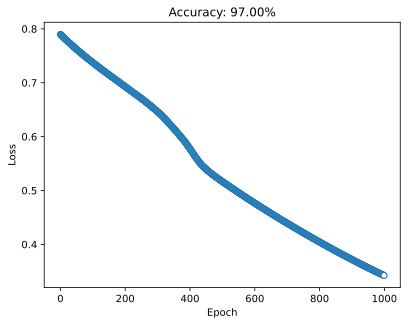

In [180]:
plt.plot(losses.detach(), "o", markerfacecolor="w")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Accuracy: {:.2f}%'.format(total_accuracy * 100))
plt.show()

In [181]:
# Test with several learning rates
#learning_rates = np.linspace(0.001, 0.1, 40) 
learning_rates = np.logspace(-3, 1, num=50, base=10) # logarithmic spacing to cover a wider range of learning rates
accuracies = np.zeros(len(learning_rates))
all_losses = np.zeros((len(learning_rates), num_epochs))

for i, lr in enumerate(learning_rates):
    model, loss_fn, optimizer = createANNmodel(lr)
    losses = trainANNmodel(model, loss_fn, optimizer, data, labels, num_epochs)
    all_losses[i] = losses.detach().numpy()
    
    # compute predictions and accuracy
    logits = model(data).squeeze()
    predicted_labels = (logits >= 0.0).float() # threshold at 0.0 since we are using BCEWithLogitsLoss
    accuracy = (predicted_labels == labels).float().mean().item()
    accuracies[i] = accuracy

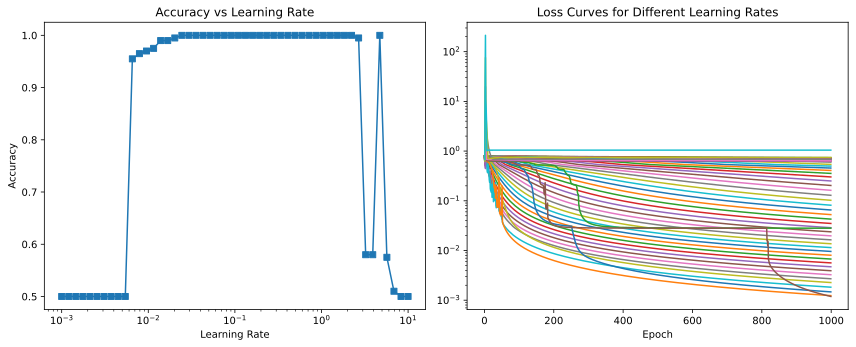

In [182]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(learning_rates, accuracies, 's-')
ax[0].set_xscale('log') # set x-axis to logarithmic scale for better visualization
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy vs Learning Rate')

ax[1].plot(all_losses.T)
ax[1].set_yscale('log') # set y-axis to logarithmic scale to better visualize loss curves that can vary widely
ax[1].set_xlabel('Epoch')
ax[1].set_title('Loss Curves for Different Learning Rates')
plt.tight_layout()
plt.show()

In [184]:
# proportion of runs where the model had at elast 70% accuracy
successful_runs = (accuracies >= 0.7).sum() / len(learning_rates)
print(f'Successful runs (accuracy >= 70%): {successful_runs * 100:.2f}%')

Successful runs (accuracy >= 70%): 68.00%


In [129]:
# now we wont fix the random seed in createANNmodel to see how different initial weights affect the training 
# process and final accuracy across different learning rates. We will run multiple experiments for each learning 
# rate and compute the average accuracy across experiments to get a more robust estimate of the performance of
#  each learning rate. Since if we run just one then the solution for that lr will depend on luck of the initial 
# weights and might not be representative of the general performance of that learning rate.

num_experiments = 50
num_epochs = 500
accuracies_exp = np.zeros((num_experiments, len(learning_rates)))
losses_exp = np.zeros((num_experiments, len(learning_rates), num_epochs))
for exp_i in range(num_experiments):
    for i, lr in enumerate(learning_rates):
        seed = np.random.randint(0, 10000) # different random seed for each run to have different initial weights
        model, loss_fn, optimizer = createANNmodel(lr, seed=seed) # different seed for each experiment
        losses = trainANNmodel(model, loss_fn, optimizer, data, labels, num_epochs)
        
        # compute predictions and accuracy
        logits = model(data).squeeze()
        predicted_labels = (logits >= 0.0).float() # threshold at 0.0 since we are using BCEWithLogitsLoss
        accuracy = (predicted_labels == labels).float().mean().item()
        accuracies_exp[exp_i, i] = accuracy

Text(0, 0.5, 'Average Accuracy across Experiments')

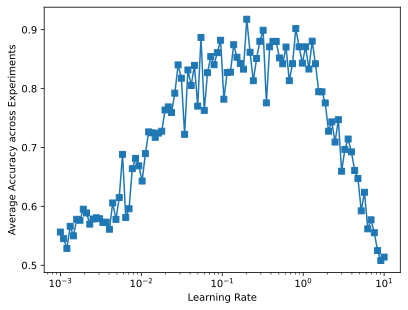

In [130]:
# compute the average accuracy across experiments for each learning rate
average_accuracies = accuracies_exp.mean(axis=0)
plt.plot(learning_rates, average_accuracies, 's-')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Average Accuracy across Experiments')

In [188]:
# we can use a more complex model with more layers and neurons to see how it behaves
def createANNmodelComplex(learning_rate, seed=13):
    torch.manual_seed(seed) # for reproducibility and to have the same initial weights across different runs
    model = nn.Sequential(
        nn.Linear(2, 16), # we have selected 16, but this is a hyperparameter that can be tuned
        nn.ReLU(),
        nn.Linear(16, 1), # hidden layer, the input size needs to match the output size of the previous layer
        nn.ReLU(),
        nn.Linear(1, 1), 
    )

    # this is more correct for binary classification, but we will use the one above for learning purposes
    # model = nn.Sequential(    
    #     nn.Linear(2, 16),
    #     nn.ReLU(),
    #     nn.Linear(16, 1),
    # )

    loss_fn = nn.BCEWithLogitsLoss() # combines sigmoid and binary cross-entropy loss
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    return model, loss_fn, optimizer

def createLinear(learning_rate, seed=13):
    torch.manual_seed(seed) # for reproducibility and to have the same initial weights across different runs
    model = nn.Sequential(
        nn.Linear(2, 16), # we have selected 16, but this is a hyperparameter that can be tuned
        nn.Linear(16, 1), # hidden layer, the input size needs to match the output size of the previous layer
        nn.Linear(1, 1), 
        nn.Sigmoid()
    )

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    return model, loss_fn, optimizer

In [186]:
learning_rate = 0.01
num_epochs = 1000

ANNclassify, loss_fn, optimizer = createANNmodelComplex(learning_rate, seed=17)
losses = trainANNmodel(ANNclassify, loss_fn, optimizer, data, labels, num_epochs)
y_pred = ANNclassify(data).squeeze()
#predicted_labels = (y_pred > 0.5).float() # threshold at 0.5 since we are using BCELoss which outputs probabilities between 0 and 1
predicted_labels = (y_pred > 0).float() # threshold at 0 since we are using BCEWithLogitsLoss
total_accuracy = (predicted_labels == labels).float().mean().item()
print(f'Accuracy with complex model: {total_accuracy * 100:.2f}%')

Accuracy with complex model: 99.00%


In [ ]:
linear_model, loss_fn, optimizer = createLinear(learning_rate=0.1, seed=13)
losses = trainANNmodel(linear_model, loss_fn, optimizer, data, labels, num_epochs)
y_pred = linear_model(data).squeeze()
predicted_labels = (y_pred > 0.5).float() # threshold at 0.5 since we are using BCELoss
total_accuracy = (predicted_labels == labels).float().mean().item()
print(f'Accuracy with linear model: {total_accuracy * 100:.2f}%')

# It seems we perform better with the linear model, which is expected since the data is linearly separable
# Simple problems require simple solutions/models, and more complex models are not always better, especially 
# when the data is simple and doesn't require a complex model to be separated, they are better for nonlinear. 
# In fact, using a more complex model than necessary can lead to overfitting and worse performance on unseen data.

Accuracy with linear model: 100.00%
